# **Data Loading, Sampling, Splitting, and Manual PCA (no sklearn PCA)**

---



In [9]:
import numpy as np
from sklearn.datasets import fetch_openml

# Load MNIST via sklearn (0–1 classes only)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_all = mnist.data.astype(np.float32) / 255.0
y_all = mnist.target.astype(int)

# Filter to classes 0 and 1
mask_train = (y_all[:60000] == 0) | (y_all[:60000] == 1)
mask_test  = (y_all[60000:] == 0) | (y_all[60000:] == 1)
X_tr_full = X_all[:60000][mask_train]
y_tr_full = y_all[:60000][mask_train]
X_te_full = X_all[60000:][mask_test]
y_te_full = y_all[60000:][mask_test]

# Sample exactly 1000 per class for training
idx0 = np.where(y_tr_full == 0)[0]
idx1 = np.where(y_tr_full == 1)[0]
sel0 = np.random.choice(idx0, 1000, replace=False)
sel1 = np.random.choice(idx1, 1000, replace=False)
X_sel = np.vstack([X_tr_full[sel0], X_tr_full[sel1]])
y_sel = np.hstack([y_tr_full[sel0], y_tr_full[sel1]])

# Shuffle and split 80/20 into train/val
perm = np.random.permutation(len(y_sel))
X_sel, y_sel = X_sel[perm], y_sel[perm]
split = int(0.8 * len(y_sel))
X_train, y_train = X_sel[:split], y_sel[:split]
X_val,   y_val   = X_sel[split:], y_sel[split:]

# Prepare test set (all 0/1 test samples)
X_test = X_te_full
y_test = y_te_full

# Convert labels to ±1
y_train = np.where(y_train == 0, -1, +1)
y_val   = np.where(y_val   == 0, -1, +1)
y_test  = np.where(y_test  == 0, -1, +1)

# Manual PCA to 5 dimensions
def manual_pca(X, k):
    mu = X.mean(axis=0)
    Xc = X - mu
    cov = (Xc.T @ Xc) / Xc.shape[0]
    eig_vals, eig_vecs = np.linalg.eigh(cov)
    idx = np.argsort(eig_vals)[::-1][:k]
    return eig_vecs[:, idx], mu

components, mean_vec = manual_pca(X_train, 5)
X_train = (X_train - mean_vec) @ components
X_val   = (X_val   - mean_vec) @ components
X_test  = (X_test  - mean_vec) @ components

print("Shapes after PCA →", X_train.shape, X_val.shape, X_test.shape)


Shapes after PCA → (1600, 5) (400, 5) (2115, 5)


# ***Decision Stump for AdaBoost***

---



In [10]:
class DecisionStump:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y, w):
        n, d = X.shape
        best_err = np.inf
        for j in range(d):
            col = X[:, j]
            cuts = np.linspace(col.min(), col.max(), 3)
            for t in cuts:
                for p in (+1, -1):
                    pred = np.ones(n)
                    pred[p * col < p * t] = -1
                    err = np.sum(w * (pred != y))
                    if err < best_err:
                        best_err = err
                        self.feature, self.threshold, self.polarity = j, t, p

    def predict(self, X):
        col = X[:, self.feature]
        pred = np.ones(len(col))
        pred[self.polarity * col < self.polarity * self.threshold] = -1
        return pred

# ***AdaBoost Training Loop***

---



In [11]:
M = 200
n = X_train.shape[0]
w = np.full(n, 1/n)
models, betas = [], []
train_loss, val_loss, test_loss = [], [], []

for m in range(1, M+1):
    stump = DecisionStump()
    stump.fit(X_train, y_train, w)
    pred_tr = stump.predict(X_train)

    # Weighted error and classifier weight
    err = np.sum(w * (pred_tr != y_train)) / w.sum()
    beta = 0.5 * np.log((1 - err) / (err + 1e-10))

    # Update sample weights
    w *= np.exp(-beta * y_train * pred_tr)
    w /= w.sum()

    models.append(stump)
    betas.append(beta)

    # Boosted prediction function
    def boosted_predict(X):
        F = sum(b * mdl.predict(X) for mdl, b in zip(models, betas))
        return np.sign(F)

    # Record losses
    train_loss.append(np.mean(boosted_predict(X_train) != y_train))
    val_loss.append(np.mean(boosted_predict(X_val)   != y_val))
    test_loss.append(np.mean(boosted_predict(X_test)  != y_test))

print("AdaBoost complete.")

AdaBoost complete.


# **Plotting Results**

---



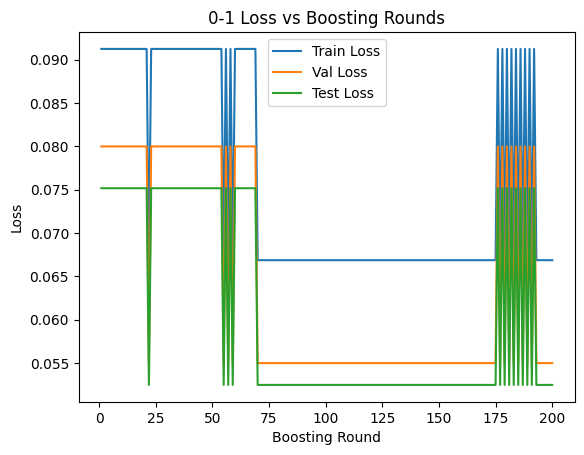

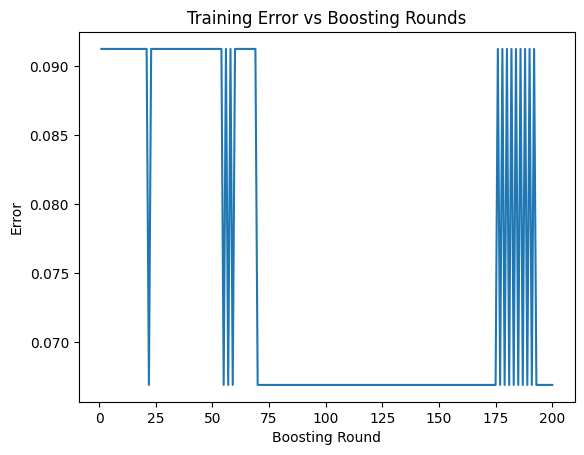

In [ ]:
import matplotlib.pyplot as plt
rounds = np.arange(1, M+1)

# Plot 1: Train/Val/Test 0-1 Loss
plt.figure()
plt.plot(rounds, train_loss, label='Train Loss')
plt.plot(rounds, val_loss,   label='Val Loss')
plt.plot(rounds, test_loss,  label='Test Loss')
plt.title('0-1 Loss vs Boosting Rounds')
plt.xlabel('Boosting Round'); plt.ylabel('Loss')
plt.legend(); plt.show()

# Plot 2: Training Error vs Boosting Rounds
plt.figure()
plt.plot(rounds, train_loss)
plt.title('Training Error vs Boosting Rounds')
plt.xlabel('Boosting Round'); plt.ylabel('Error')
plt.show()

final_test_loss = test_loss[-1]
final_test_acc  = 1 - final_test_loss
print(f"Final Test Accuracy: {final_test_acc*100:.2f}%")
